In [ ]:
# MNIST experiment from scratch
!pip install nengo
!pip install numpy
!pip install sklearn
!pip install  matplotlib

     |████████████████████████████████| 532kB 6.1MB/s 


In [ ]:
import nengo
import numpy as np
import sklearn.datasets
import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
#fetch data
mnist = sklearn.datasets.fetch_openml('mnist_784')

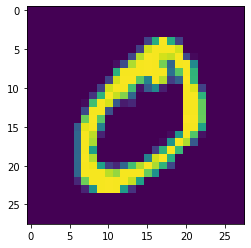

In [ ]:
#DEBUG (view data)
sample = 1
image = mnist['data'][sample]
image = image.reshape(28,28)

# plot the sample
plt.imshow(image)
plt.show()

In [ ]:
## data preprocessing
x = mnist['data'].astype(float)-128
x = x/np.linalg.norm(x, axis=1)[:,None]
       
y = mnist['target']
y = np.eye(10)[y.astype(int)]*2-1
y = y/np.linalg.norm(y, axis=1)[:,None]

order = np.arange(len(x))
np.random.shuffle(order)
x = x[order]
y = y[order]

In [ ]:
#parameters

n_training=5000
n_testing=100

n_neurons=500*2
synapse=0.02
t_image=0.5
dt = 0.001

In [ ]:
## nengo 

## define data for stim_func; find out why it is not the complete dataset

model = nengo.Network()
with model:
    #input image made up of 784 components (used for testing)
    def stim_func(t, data=x[n_training:]):
        index = int(t / t_image)
        return data[index % len(data)]

    #this is the expected output for a given image (values from 0-9) (used for testing)
    def result_func(t, raw, correct=y[n_training:]):
                index = int((t-dt) / t_image)
                c = np.argmax(correct[index])
                r = np.argmax(raw)
                return np.hstack([raw, c, r])
    
    
    stim = nengo.Node(stim_func)
   
   #only the Ensemble is for training
    ens = nengo.Ensemble(n_neurons = n_neurons, 
                         dimensions=784,
                         intercepts=nengo.dists.CosineSimilarity(784+2), #need clarification on the intercept used!!!
                         neuron_type=nengo.RectifiedLinear()) #RL neuron scales the activity linearly with 
                                                              #~ current(stay at zero if activity below zero but is N/A in this case)
    
    result = nengo.Node(result_func, size_in=10)
    nengo.Connection(stim, ens, synapse=None)

    #This line is for training
    nengo.Connection(ens, 
                         result, 
                         eval_points=x[:n_training], 
                         function=y[:n_training],
                         solver=nengo.solvers.LstsqL2(reg=0.1),
                         synapse=synapse)
    output = nengo.Probe(result)

In [ ]:
with nengo.Simulator(model) as sim:  # Create the simulator
    T = n_testing * t_image #why multiply the testing number by the time per image. is t to get the total Time the simulation should take to evaluate all images??? or to cheach if its enough time to evaluate all image???
    sim.run(T)

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

0.89


(0.0, 10.0)

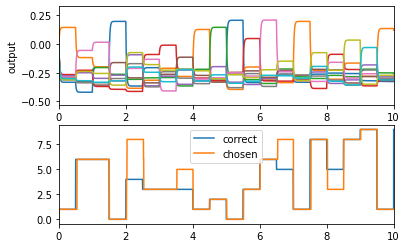

In [ ]:
correct = sim.data[output][:,10].astype(int)
result = sim.data[output][:,11].astype(int)

confusion = np.zeros((10,10), dtype=int)
count = np.zeros(10, dtype=int)

times = sim.trange()

#Calculate the training error
for i in range(n_testing):
    t = (i + 1) * t_image
    index = np.argmax(times >= t) - 1
    count[correct[index]] += 1
    confusion[correct[index],result[index]] += 1
score = sum(confusion[i, i] for i in range(10)) / float(n_testing)
print(score)

plt.subplot(2, 1, 1)
plt.plot(sim.trange(), sim.data[output][:,:10])
plt.xlim(0, t_image * min(n_testing, 20))
plt.ylabel('output')
plt.subplot(2, 1, 2)
plt.plot(sim.trange(), sim.data[output][:,10:])
plt.legend(['correct', 'chosen'], loc='best')
plt.xlim(0, t_image * min(n_testing, 20))